In [71]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [72]:
# let's check the video card
!nvidia-smi

Mon Apr  5 13:47:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    32W / 250W |   2635MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [73]:
# install the dependencies
!pip install kaggle

In [74]:
# upload Kaggle API
# from google.colab import files
# files.upload()

In [75]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permission
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c nlp-getting-started

test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import time

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional, GlobalAveragePooling1D, Conv1D, MaxPooling1D, BatchNormalization, Flatten
from keras import initializers, regularizers, constraints, layers
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score

In [77]:
# load data
PATH = '/content/'

train_data = pd.read_csv(PATH + 'train.csv')
# print train data
display(train_data)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [78]:
# Drop columns
train_data = train_data.drop(['id', 'keyword', 'location'], axis=1)
display(train_data)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


In [104]:
# Check real time
cur_time = time.time()
maxWordsCount = 20000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', 
                      lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(train_data['text'])
list_train = tokenizer.texts_to_sequences(train_data['text'])
print('Spend time: ', round(time.time() - cur_time, 2), 'c', sep='')
print(list_train)

Время обработки: 0.3c
[[120, 4634, 25, 5, 869, 9, 22, 264, 139, 1620, 4635, 90, 41], [190, 46, 230, 800, 6955, 6956, 1405], [41, 1752, 1621, 8, 6957, 7, 6958, 25, 137, 6959, 21, 1753, 40, 442, 257, 58, 2159, 7, 715, 1406, 25, 1107], [836, 2922, 60, 4636, 1501, 257, 1406, 7, 97], [35, 101, 1222, 22, 321, 23, 6960, 2160, 31, 272, 23, 1501, 6961, 70, 6, 188], [2923, 379, 97, 1502, 801, 870, 7, 666, 6962, 564, 8, 1160, 400, 46, 4637, 1501], [219, 77, 871, 296, 1223, 837, 265, 9, 1754, 7, 6963, 1048, 2454, 1503], [47, 14, 231, 9, 5, 1934, 10, 11, 75, 111, 6, 46, 7, 5, 4638], [423, 44, 76, 257, 1305, 52, 7, 5, 595, 872, 5, 770], [47, 2455, 18, 5, 470, 12, 251, 8, 120, 279], [596, 60, 642, 23, 5, 280, 471, 36, 643], [873, 565, 2924, 12, 232, 2925, 3598, 691, 6, 716, 11, 201, 7, 565, 2924, 61, 176, 11, 322, 72, 61, 176, 11, 322, 72, 6964, 265], [2926, 265, 2161, 6965, 2924, 951, 58, 1935, 620, 359, 739, 3599], [219, 7, 4639, 952, 50, 1755, 4639], [233, 8, 188, 424, 14, 3600, 7, 2927, 131, 93, 

In [105]:
# Parametrs
max_len = 2000
embedding_size = 128
x_tr = pad_sequences(list_train, maxlen=max_len) 
y_tr = train_data['target']

# Get x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = train_test_split(x_tr, y_tr, test_size=0.05, random_state=42)
print(f'x_train shape={x_train.shape}, x_test shape={x_test.shape}')
print(f'y_train shape={y_train.shape}, y_test shape={y_test.shape}')

x_train shape=(7232, 2000), x_test shape=(381, 2000)
y_train shape=(7232,), y_test shape=(381,)


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 2000, 200)         4000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1996, 256)         256256    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 399, 256)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 399, 256)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 399, 256)          1024      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 395, 128)          163968    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 79, 128)         

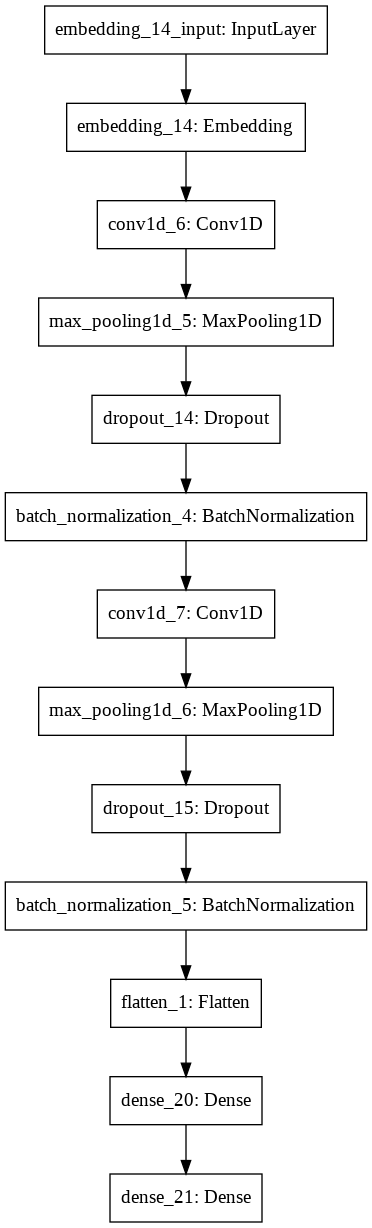

In [107]:
# Create model
model = Sequential()
model.add(Embedding(maxWordsCount, 200, input_length = max_len))

model.add(Conv1D(256, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

model.summary()
plot_model(model, to_file='model1.png')

Epoch 1/15
181/181 [==============================] - 11s 50ms/step - loss: 0.7452 - accuracy: 0.5807 - val_loss: 0.6802 - val_accuracy: 0.5667
Epoch 2/15
181/181 [==============================] - 9s 49ms/step - loss: 0.3825 - accuracy: 0.8523 - val_loss: 0.8133 - val_accuracy: 0.5701
Epoch 3/15
181/181 [==============================] - 9s 48ms/step - loss: 0.2711 - accuracy: 0.9000 - val_loss: 0.8414 - val_accuracy: 0.6738
Epoch 4/15
181/181 [==============================] - 9s 48ms/step - loss: 0.1520 - accuracy: 0.9530 - val_loss: 0.5535 - val_accuracy: 0.7733
Epoch 5/15
181/181 [==============================] - 9s 48ms/step - loss: 0.1014 - accuracy: 0.9701 - val_loss: 1.2625 - val_accuracy: 0.7602
Epoch 6/15
181/181 [==============================] - 9s 48ms/step - loss: 0.0783 - accuracy: 0.9740 - val_loss: 2.6645 - val_accuracy: 0.7761
Epoch 7/15
181/181 [==============================] - 9s 48ms/step - loss: 0.0726 - accuracy: 0.9765 - val_loss: 8.5013 - val_accuracy: 0.676

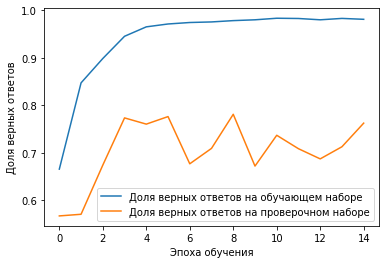

In [108]:
history = model.fit(x_train, 
                      y_train, 
                      epochs=15,
                      batch_size=32,
                      validation_split=0.2)

plt.plot(history.history['accuracy'], 
         label='Percentage of correct answers in the training set')
plt.plot(history.history['val_accuracy'], 
         label='Percentage of correct answers on the test set')
plt.xlabel('The Age of Learning')
plt.ylabel('Percentage of correct answers')
plt.legend()
plt.show()

In [115]:
import sklearn
predicted=model.predict(x_test)
precision, recall, fscore, support = score(y_test, predicted.round())

print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'fscore: {fscore}')
print(f'support: {support}')
print(sklearn.metrics.classification_report(y_test, predicted.round()))

precision: [0.71481481 0.85585586]
recall: [0.92344498 0.55232558]
fscore: [0.80584551 0.67137809]
support: [209 172]
              precision    recall  f1-score   support

           0       0.71      0.92      0.81       209
           1       0.86      0.55      0.67       172

    accuracy                           0.76       381
   macro avg       0.79      0.74      0.74       381
weighted avg       0.78      0.76      0.75       381

